Paper: https://arxiv.org/abs/1611.07004

In [ ]:
!pip -q install torchinfo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image

import os
import glob
import random

import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Helper Utility

In [ ]:
def find_all_png_paths(directory_path):
    """
    Finds all .png files in the given directory and all its subdirectories.

    Args:
        directory_path (str): The starting directory path.

    Returns:
        list: A list of paths to all .png files found.
    """
    # Create the search pattern: combine the directory path with '**/*.png'
    # os.path.join handles correct path separators for different operating systems
    search_pattern = os.path.join(directory_path, '**', '*.png')

    # Use glob.glob with recursive=True to search subdirectories
    # The ** pattern matches any directory recursively
    png_files = glob.glob(search_pattern, recursive=True)

    return png_files

In [ ]:
def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
both_transform = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        # A.HorizontalFlip(p=0.5),   # mirroring only
        A.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

# Discriminator Model

In [ ]:
class BuildConv2dBlockDiscriminator(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(BuildConv2dBlockDiscriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        # Create initial CNN block with no BN and only LeakeyReLU
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        # Create remaing CNN block with BN and LeakeyReLU
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                BuildConv2dBlockDiscriminator(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )

        # Extract all remaining CNN Layers
        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x

In [ ]:
# # Testing model
# x = torch.randn((1, 3, 256, 256))
# y = torch.randn((1, 3, 256, 256))

# model = Discriminator(in_channels=3)
# preds = model(x, y)
# print(preds.shape)

In [ ]:
# # print(model)
# summary(model, input_size=((1, 3, 256, 256), (1, 3, 256, 256)))

# Generator Model

In [ ]:
# print("hello") if False else print("bye")

In [ ]:
class BuildBlockGenerator(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(BuildBlockGenerator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = BuildBlockGenerator(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = BuildBlockGenerator(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = BuildBlockGenerator(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = BuildBlockGenerator(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = BuildBlockGenerator(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = BuildBlockGenerator(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )

        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = BuildBlockGenerator(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = BuildBlockGenerator(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = BuildBlockGenerator(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = BuildBlockGenerator(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = BuildBlockGenerator(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = BuildBlockGenerator(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = BuildBlockGenerator(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [ ]:
# x = torch.randn((1, 3, 256, 256))
# model = Generator(in_channels=3, features=64)

# preds = model(x)
# print(preds.shape)

In [ ]:
# print(summary(model, input_size=(1, 3, 256, 256)))
# print(model)

# Hyper Parameters

In [ ]:
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
NUM_EPOCHS = 200
L1_LAMBDA = 100

LOAD_MODEL = True
SAVE_MODEL = True

CHECKPOINT_DISC = "/content/drive/MyDrive/BENCOLOR/checkpoints/disc.pth.tar"
CHECKPOINT_GEN = "/content/drive/MyDrive/BENCOLOR/checkpoints/gen.pth.tar"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

TRAIN_DATA_SHUFFLE = True
VAL_DATA_SHUFFLE = False
TEST_DATA_SHUFFLE = True

DATASET_ROOT_DIR = '/content/drive/MyDrive/BENCOLOR/move_dataset'

# Set the seed
SEED_VALUE = 24
random.seed(SEED_VALUE)

# Dataset Pipeline

In [ ]:
all_png_paths = find_all_png_paths(DATASET_ROOT_DIR)

# Shuffle the list in-place
random.shuffle(all_png_paths)

train_paths, val_paths = train_test_split(all_png_paths, test_size=0.2, random_state=42)
val_paths, test_paths = train_test_split(all_png_paths, test_size=0.5, random_state=42)

print(f"Train size: {len(train_paths)}")
print(f"Val size: {len(val_paths)}")
print(f"Test size: {len(test_paths)}")

Train size: 6848
Val size: 4280
Test size: 4280


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, train_frame_paths):
        self.train_frame_paths = train_frame_paths

    def __len__(self):
        return len(self.train_frame_paths)

    def __getitem__(self, idx):
        img_path = self.train_frame_paths[idx]
        image = Image.open(img_path)

        input_image = np.array(image.convert("L").convert("RGB"))
        target_image = np.array(image)

        augmentations = both_transform(image=input_image, image0=target_image)
        input_image = augmentations["image"]
        target_image = augmentations["image0"]

        input_image = transform_only_input(image=input_image)["image"]
        target_image = transform_only_mask(image=target_image)["image"]

        return input_image, target_image

In [ ]:
train_dataset = CustomDataset(train_paths)
val_dataset = CustomDataset(val_paths)
test_dataset = CustomDataset(test_paths)

Input image shape: torch.Size([3, 256, 256])
Target image shape: torch.Size([3, 256, 256])


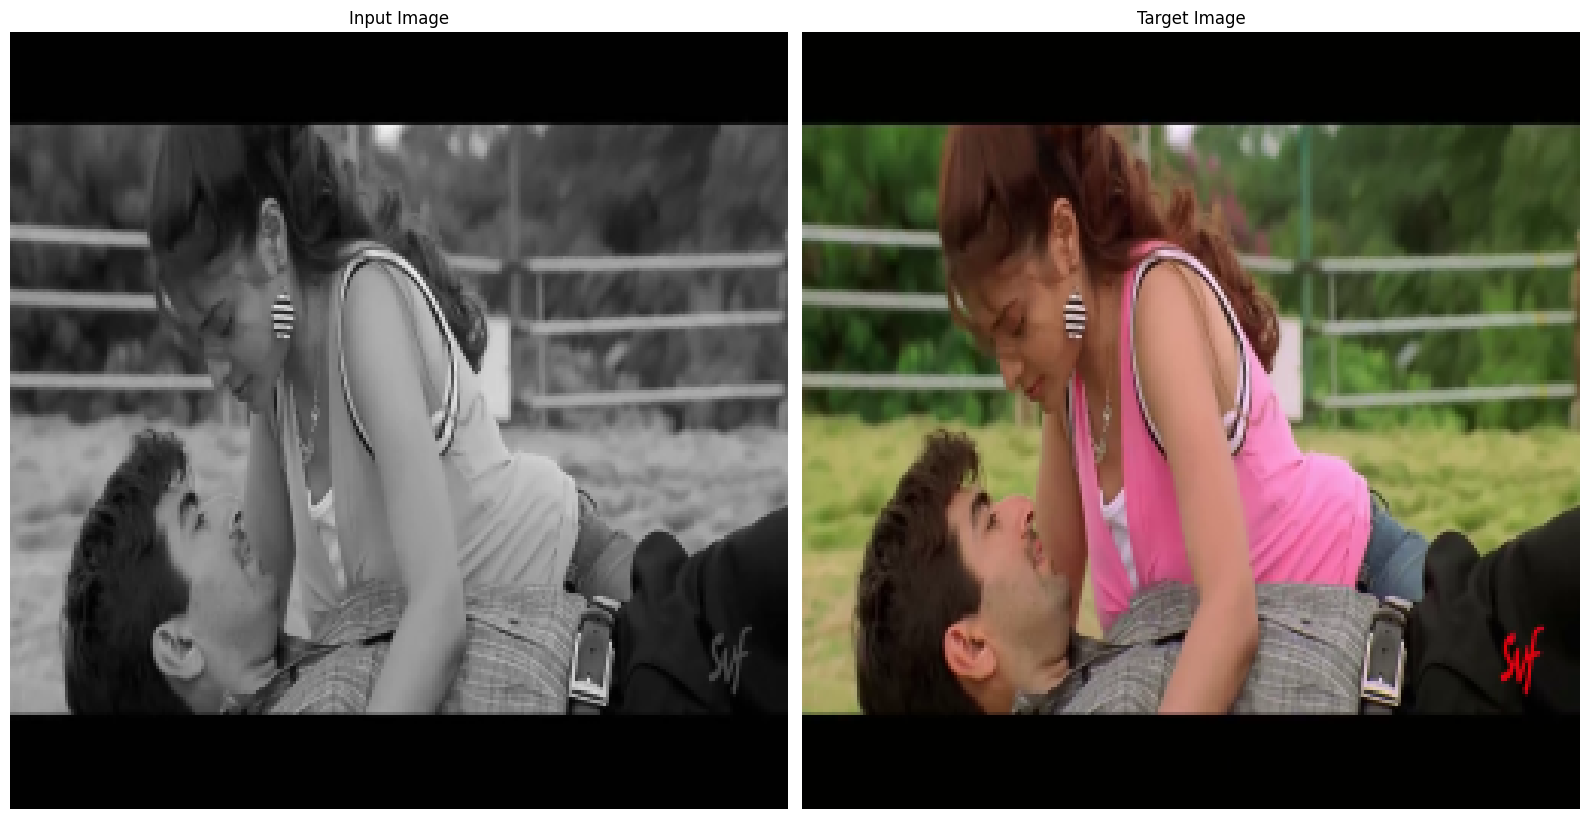

In [ ]:
input_image, target_image = train_dataset[10]

print(f"Input image shape: {input_image.shape}")
print(f"Target image shape: {target_image.shape}")

fig, ax = plt.subplots(1, 2, figsize=(16, 16))

ax[0].imshow(input_image.permute(1, 2, 0) * 0.5 + 0.5) # remove normalization using norm_img * 0.5 + 0.5
ax[0].axis('off')
ax[0].set_title("Input Image")

ax[1].imshow(target_image.permute(1, 2, 0) * 0.5 + 0.5)
ax[1].axis('off')
ax[1].set_title("Target Image")

plt.tight_layout()
plt.show()

In [ ]:
print(f"Min Input: {input_image.min()}, Max Input: {input_image.max()}")
print(f"Min Target: {target_image.min()}, Max Target: {target_image.max()}\n")

print(f"Input datatype: {input_image.dtype}")
print(f"Target data type: {target_image.dtype}")

Min Input: -1.0, Max Input: 0.9058824181556702
Min Target: -1.0, Max Target: 1.0

Input datatype: torch.float32
Target data type: torch.float32


In [ ]:
# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=TRAIN_DATA_SHUFFLE)
# val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=VAL_DATA_SHUFFLE)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=TEST_DATA_SHUFFLE)

# Traning Pipeline

In [ ]:
def train_fn(
    disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler,
):
    disc.train()
    gen.train()

    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # Train Discriminator
        with torch.amp.autocast(device_type=DEVICE):
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.amp.autocast(device_type=DEVICE):
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )

In [ ]:
def main():
    disc = Discriminator(in_channels=3).to(DEVICE)
    gen = Generator(in_channels=3, features=64).to(DEVICE)

    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE,
        )

    g_scaler = torch.amp.GradScaler(device=DEVICE)
    d_scaler = torch.amp.GradScaler(device=DEVICE)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=TRAIN_DATA_SHUFFLE)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=VAL_DATA_SHUFFLE)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=TEST_DATA_SHUFFLE)

    print(f"Train size: {len(train_dataloader)}")
    print(f"Val size: {len(val_dataloader)}")
    print(f"Test size: {len(test_dataloader)}\n")

    for epoch in range(NUM_EPOCHS):
        train_fn(
            disc, gen, train_dataloader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler,
        )

        if SAVE_MODEL and epoch % 5 == 0:
            save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)

        save_some_examples(gen, val_dataloader, epoch, folder="/content/drive/MyDrive/BENCOLOR/evaluation")

In [ ]:
main()

# Prediction

In [ ]:
def uploaded_images(uploaded_image_dir='upload'):
    from google.colab import files
    from pathlib import Path
    import os
    import shutil

    os.makedirs(uploaded_image_dir, exist_ok=True)

    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

    uploaded = files.upload()
    uploaded_image_paths = list(uploaded.keys())

    image_paths = []
    for image_path in uploaded_image_paths:
        suffix = Path(image_path).suffix.lower()

        if suffix in image_extensions:
            dest_path = os.path.join(uploaded_image_dir, image_path)
            shutil.move(image_path, dest_path)   # handles spaces
            image_paths.append(dest_path)
        else:
            os.remove(image_path)
            print(f"Skipping non-image file: {image_path}")

    return image_paths

In [ ]:
def predict_single_image(image_path, gen, output_file_path):
  gen.eval()
  image = Image.open(image_path)
  image = image.resize((256, 256))
  input_image_np = np.array(image.convert("L").convert("RGB")) # Get numpy array in [0, 255]

  # Apply the same transformation as during training for the input image
  transformed_input_image = transform_only_input(image=input_image_np)["image"]

  y_pred = gen(transformed_input_image.unsqueeze(0).to(DEVICE)) # Feed the transformed tensor to the generator

  y_pred = y_pred.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
  y_pred = (y_pred * 0.5 + 0.5) * 255
  y_pred = y_pred.astype(np.uint8)
  y_pred = Image.fromarray(y_pred)

  # Save the image directly to the provided output_file_path
  y_pred.save(output_file_path)
  print(f"Saved output to {output_file_path}")

In [ ]:
def predict_images(output_result_dir):
  os.makedirs(output_result_dir, exist_ok=True)
  gen = Generator(in_channels=3, features=64).to(DEVICE)

  # Load only the generator's state_dict for prediction
  checkpoint = torch.load(CHECKPOINT_GEN, map_location=DEVICE)
  gen.load_state_dict(checkpoint["state_dict"])
  print("Loaded generator's state_dict for prediction")

  gen.eval() # Set generator to evaluation mode for consistent inference

  uploaded_image_paths = uploaded_images(uploaded_image_dir="upload")

  for image_path in uploaded_image_paths:
    # Construct the full output file path
    output_file_path = os.path.join(output_result_dir, os.path.basename(image_path))
    predict_single_image(image_path, gen, output_file_path)

In [ ]:
predict_images(output_result_dir="result")

# Save GIF

In [ ]:
import os
import re
from PIL import Image

IMAGE_DIR = "/content/drive/MyDrive/BENCOLOR/evaluation"
OUTPUT_GIF = "training.gif"
FPS = 24


def extract_epoch(fname):
    m = re.match(r"y_gen_(\d+)\.png$", fname)
    return int(m.group(1)) if m else None


# ---- Collect files ----
epoch_files = []
for f in os.listdir(IMAGE_DIR):
    epoch = extract_epoch(f)
    if epoch is not None:
        epoch_files.append((epoch, f))

if not epoch_files:
    raise RuntimeError("No y_gen_<epoch>.png files found!")

# ---- Sort numerically (0 → N) ----
epoch_files.sort(key=lambda x: x[0])

# ---- Explicit check ----
print("First image :", epoch_files[0][1])
print("Last image  :", epoch_files[-1][1])  # ✅ GUARANTEED last

# ---- Load all frames (including last) ----
frames = []
for _, fname in epoch_files:
    img_path = os.path.join(IMAGE_DIR, fname)
    frames.append(Image.open(img_path).convert("RGB"))

assert len(frames) == len(epoch_files), "Frame drop detected!"

# ---- Save GIF ----
frames[0].save(
    OUTPUT_GIF,
    save_all=True,
    append_images=frames[1:],   # includes last frame
    duration=int(1000 / FPS),
    loop=0
)

print(f"GIF created with {len(frames)} frames -> {OUTPUT_GIF}")


In [ ]:
!ls -lh /content/training.gif

-rw-r--r-- 1 root root 51M Jan 24 15:51 /content/training.gif
